In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/

In [54]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/255.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

In [37]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            rgb = sorted(glob.glob(path+"r-*"))
            depth = sorted(glob.glob(path+"d-*"))
            samples.extend(zip(rgb,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [38]:
def generate_data_custom_nyu(samples,img_height=480,img_width=640,batch_size=8):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try:
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,3))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except(IOError,TypeError,ValueError):
                i= (i+1)%len(samples)
                continue
        yield (stack1,stack2)

In [39]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [40]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [55]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [56]:
gen  = generate_data_custom( func=normalize)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


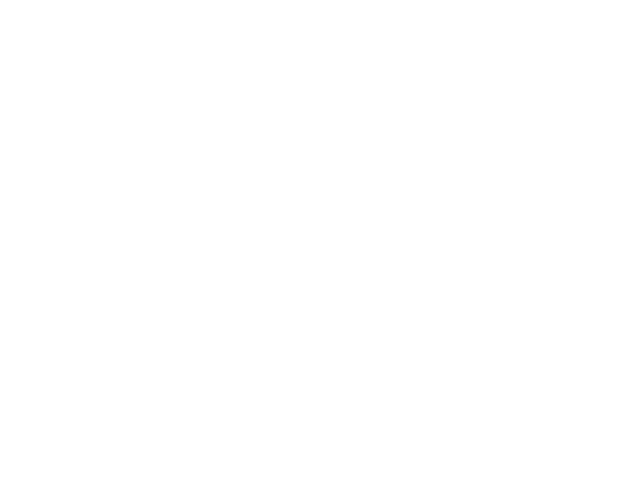

<IPython.core.display.Javascript object>


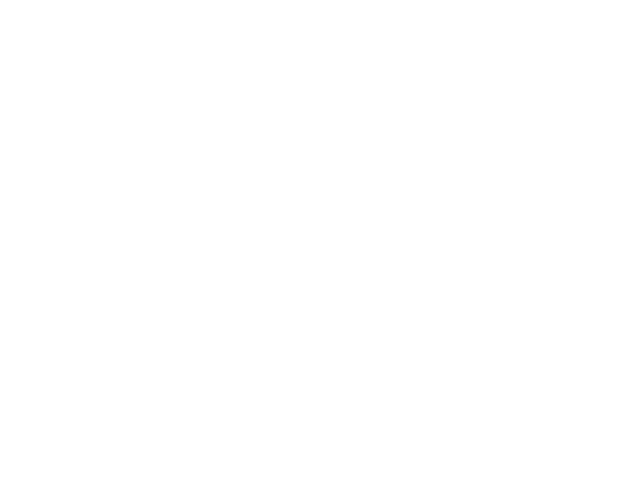

<IPython.core.display.Javascript object>


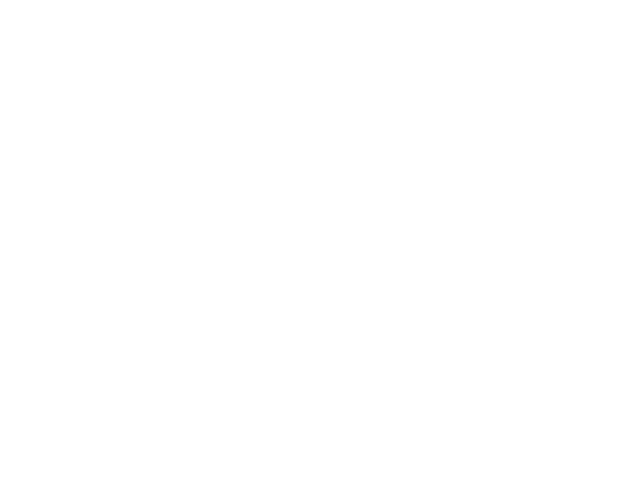

<IPython.core.display.Javascript object>


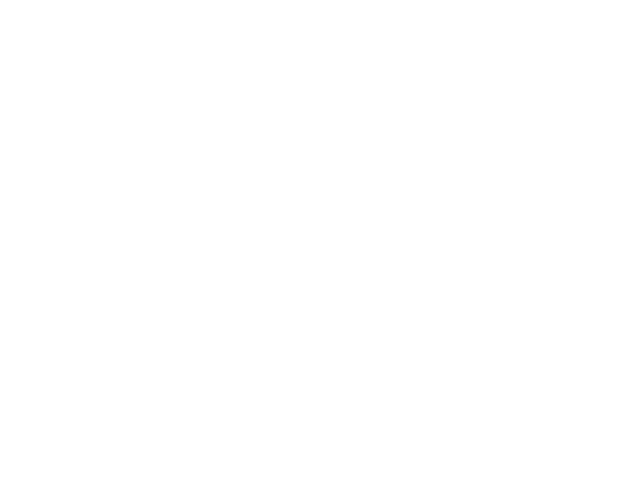

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [9]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,1))

In [53]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [31]:
model = network(inputs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 480, 640, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 480, 640, 16) 2320        conv2d_61[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 480, 640, 16) 0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [17]:
from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [82]:
model_checkpoint = ModelCheckpoint('net_depth_res.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(gen, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9119
Epoch 00001: loss improved from inf to 0.22400, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 838ms/step - loss: 0.2240 - acc: 0.9119
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9117
Epoch 00002: loss improved from 0.22400 to 0.22376, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 83s 834ms/step - loss: 0.2238 - acc: 0.9117
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9098
Epoch 00003: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.2297 - acc: 0.9096
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9075
Epoch 00004: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.2326 - acc: 0.9077
Epoch 5/1000
 99/100 [=================

Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2224 - acc: 0.9132
Epoch 00038: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.2220 - acc: 0.9134
Epoch 39/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9092
Epoch 00039: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.2328 - acc: 0.9092
Epoch 40/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9087
Epoch 00040: loss did not improve
100/100 [==============================] - 83s 835ms/step - loss: 0.2329 - acc: 0.9087
Epoch 41/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2207 - acc: 0.9132
Epoch 00041: loss did not improve
100/100 [==============================] - 83s 834ms/step - loss: 0.2213 - acc: 0.9129
Epoch 42/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2291 - acc: 0.9099
Epoch 00042: loss did not improve
100/100 [===

KeyboardInterrupt: 

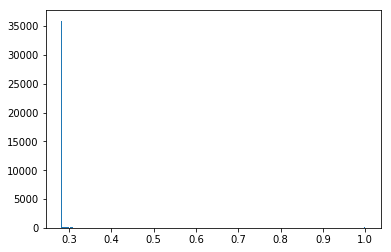

In [162]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [78]:
test = gen.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


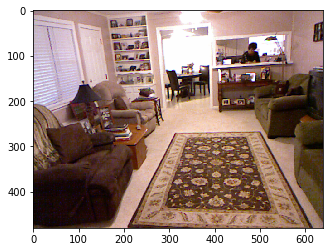

In [79]:
%matplotlib inline
img = np.reshape(X_Test[0][:,:,:],(img_height,img_width,3))
plt.imshow(img)

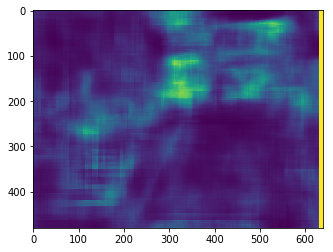

In [80]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

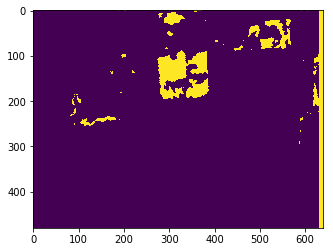

In [81]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)